In [7]:
import kagglehub
gunavenkatdoddi_eye_diseases_classification_path = kagglehub.dataset_download('gunavenkatdoddi/eye-diseases-classification')

print(PATH)


Using Colab cache for faster access to the 'eye-diseases-classification' dataset.
/kaggle/input/eye-diseases-classification/dataset


In [2]:
# Install libraries for PyTorch
!pip install torch-summary
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 9.6 MB/s eta 0:00:00


In [3]:
# Import libraries for data workings and setting compute source
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics

plt.style.use('seaborn-v0_8')
np.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Loading the data

In [10]:
PATH = '/kaggle/input/eye-diseases-classification/dataset'
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i

id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])


df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
3776,/kaggle/input/eye-diseases-classification/data...,3
3646,/kaggle/input/eye-diseases-classification/data...,3
3823,/kaggle/input/eye-diseases-classification/data...,3
1841,/kaggle/input/eye-diseases-classification/data...,1
199,/kaggle/input/eye-diseases-classification/data...,0


/tmp/ipython-input-1478327885.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')


<Axes: xlabel='outcome', ylabel='count'>

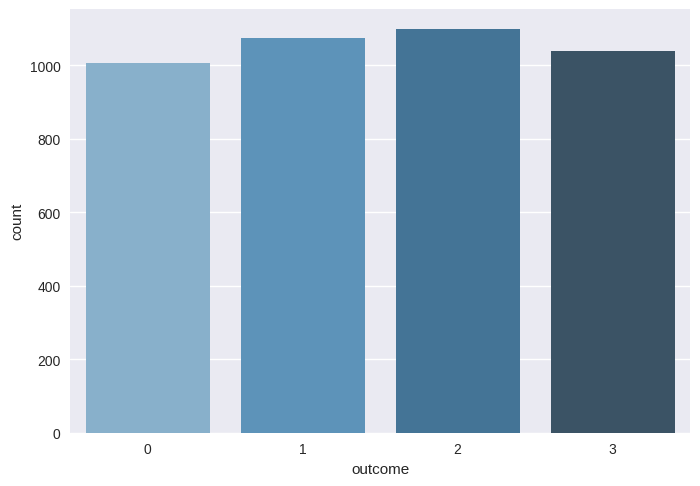

In [12]:
# Dataset distribution
sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')

In [15]:
display(id2label)

{0: 'glaucoma', 1: 'normal', 2: 'diabetic_retinopathy', 3: 'cataract'}

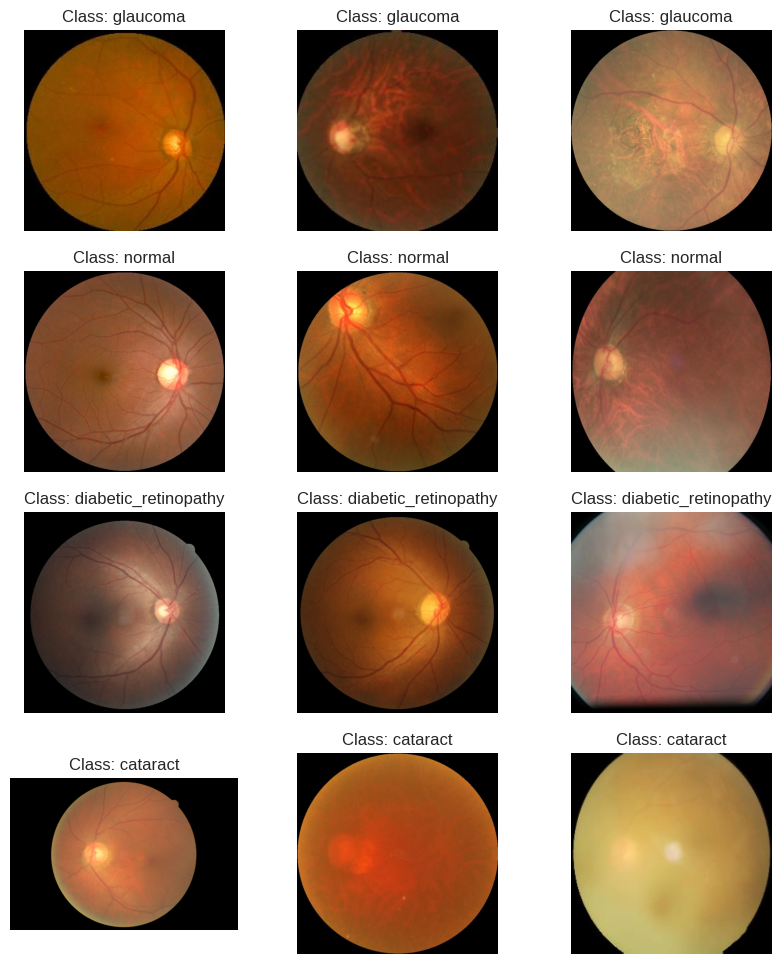

In [13]:
# Normalize image using min-max scale method range (0,1) due to image pixel differences
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1

plt.show()

In [16]:
# Import torch utilities for dataset loading followed by transformations (Random Horizontal & Vertical flip)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as f

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224))
])

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform = None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]

        img = (img - img.min())/img.max()

        if self.transform:
            img = self.transform(img)

        return img.to(torch.float32), label

In [17]:
# 85/15 (training/valid) split
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.15, random_state = 28)

df_train.shape, df_val.shape


((3584, 2), (633, 2))

In [18]:
NUM_CLASSES = 4
BATCH_SIZE = 128

train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [19]:
a, b = next(iter(train_loader))

print(a.shape, b.shape)
del(a)
del(b)

torch.Size([128, 3, 224, 224]) torch.Size([128])


In [22]:
#ResNet-18 neural network pre-trained model used (transfer learning)
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet18(pretrained = True)

# Last 15 layers are left trainable while earlier layers are frozen
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()

#Adam optimizer and setting learning rates
    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params' : self.base.parameters(), 'lr': 3e-5},
            {'params' : self.block.parameters(), 'lr': 8e-4}
        ])


    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x

#Now Eye Disease Classification

class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device

        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = NUM_CLASSES).to(self.device)

        self.history = {'train_loss' : [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)


            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


In [23]:
trainer = Trainer(train_loader, val_loader, device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


In [24]:
#Model summary
summary(trainer.model.base, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

## Model Training



In [25]:
trainer.train(epochs = 2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.734 acc: 0.709] Val: [loss: 0.449 acc:0.822]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.392 acc: 0.850] Val: [loss: 0.315 acc:0.889]


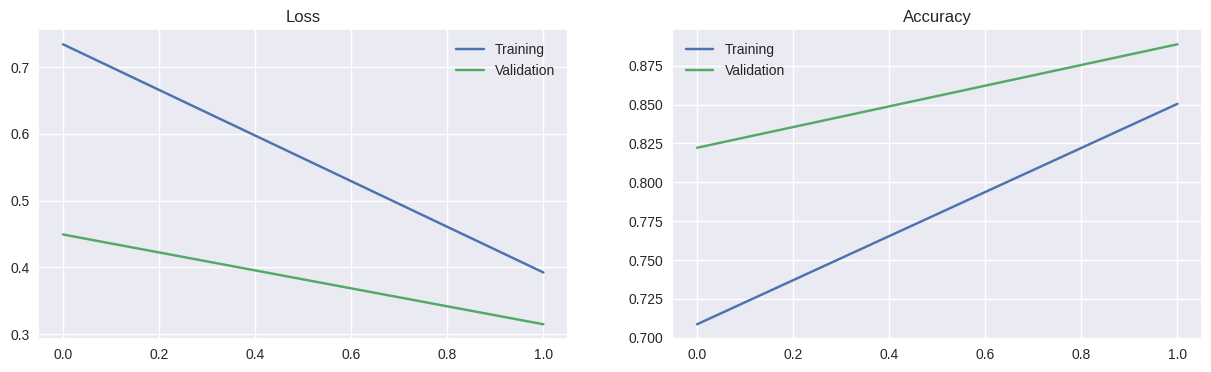

In [29]:
#Accuracy and loss line chart (accuracy goes up after second epoch and loss goes down after second epoch)
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Validation')
plt.legend()



In [31]:
# Model Predictions
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

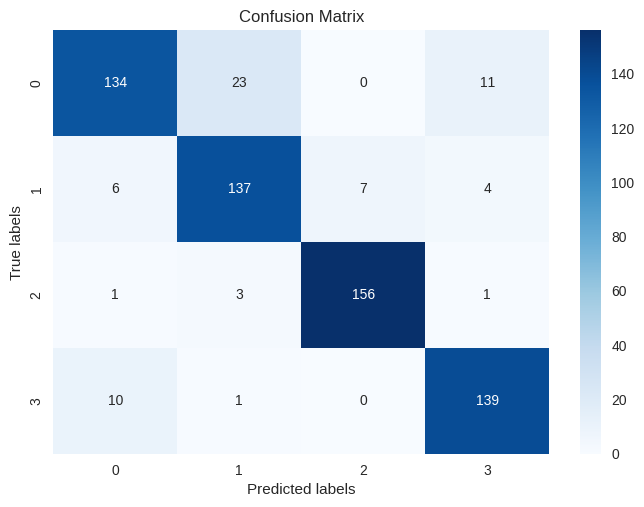

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [36]:
from sklearn.metrics import classification_report

print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            glaucoma       0.89      0.80      0.84       168
              normal       0.84      0.89      0.86       154
diabetic_retinopathy       0.96      0.97      0.96       161
            cataract       0.90      0.93      0.91       150

            accuracy                           0.89       633
           macro avg       0.89      0.90      0.89       633
        weighted avg       0.89      0.89      0.89       633

